# Dirichlet multinomial

Evaluate estimates distributions using Dirichlet-Multinomial

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import mmur
import mmu
from mmu import DirichletMultinomialConfusionMatrix

In [3]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['text.color'] = 'black'
plt.rcParams['figure.max_open_warning'] = 0
COLORS = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [4]:
def plot_metric_distributions(estimated_metrics, gt_metrics, coverage=None):
    fig, axs = plt.subplots(ncols=5, figsize=(25, 5))
    for i, c in enumerate(estimated_metrics.columns):
        sns.kdeplot(estimated_metrics[c], ax=axs[i], label='estimated')
        if coverage is not None:
            sns.kdeplot(coverage[c], ax=axs[i], label='simulated')
        axs[i].axvline(gt_metrics[c][0], c='grey', lw=2, ls='--', label='population mean')
    axs[0].legend()
    return fig, axs

In [5]:
target_metrics = [
    'neg.precision', 'pos.precision', 'neg.recall', 'pos.recall', 'mcc'
]

## Generate data

Generate data from a Logistic process with noise

#### Hold-out set

Validate the model by comparing the credible interval of the samples from the model and unseen data sampled from the data generating process.

In [6]:
generator = mmur.LogisticGenerator()
outp = generator.fit_transform(
    train_samples=10000,
    test_samples=10000,
    holdout_samples=10000,
    noise_sigma=0.3,
    enable_noise=True,
    random_state=123456
)

Select the test sets

In [7]:
y_test = outp['test']['y']
probas_test = outp['test']['proba']

Compute the confusion matrix on the test-set

In [8]:
test_conf_mat, test_metrics = mmu.binary_metrics_proba(
    y_test, probas_test, threshold=0.5
)
test_conf_mat = test_conf_mat.flatten()
test_metrics = mmu.metrics_to_dataframe(test_metrics)[target_metrics]

In [9]:
mmu.confusion_matrix_to_dataframe(test_conf_mat)

estimated         
                   negative positive
observed negative      4443      295
         positive       289     4973

In [10]:
test_metrics

,neg.precision,pos.precision,neg.recall,pos.recall,mcc
0,0.938926,0.944002,0.937737,0.945078,0.882872


In [11]:
test_conf_mat

array([4443,  295,  289, 4973])

### Ground truth

In [12]:
gt_proba_test = outp['ground_truth']['test']

Compute the ground truth confusion matrix and metrics

In [13]:
gt_conf_mat, gt_metrics = mmu.binary_metrics_proba(
    y_test, gt_proba_test, threshold=0.5
)

In [14]:
mmu.confusion_matrix_to_dataframe(gt_conf_mat)

estimated         
                   negative positive
observed negative      4440      298
         positive       288     4974

In [15]:
gt_metrics = mmu.metrics_to_dataframe(gt_metrics)[target_metrics]
gt_metrics

,neg.precision,pos.precision,neg.recall,pos.recall,mcc
0,0.939086,0.943475,0.937104,0.945268,0.882467


### Hold-out set

In [16]:
y_holdout = outp['holdout']['y']
proba_holdout = outp['holdout']['proba']

Compute metrics on this set

In [17]:
# holdout_conf_mat, holdout_metrics = mmu.binary_metrics_runs_thresholds(
#     y=y_holdout, proba=proba_holdout, thresholds=np.array((0.5, ))
# )
# holdout_metrics = mmu.metrics_to_dataframe(holdout_metrics)[target_metrics]

## Model

In [18]:
dm_model = DirichletMultinomialConfusionMatrix()

In [19]:
y_hat = dm_model.fit_predict(
    test_conf_mat,
    n_samples=10000
)

Building...



Building: found in cache, done.Messages from stanc:
Sampling:   0%
Sampling:  25% (4250/17000)
Sampling:  50% (8500/17000)
Sampling:  75% (12750/17000)
Sampling: 100% (17000/17000)
Sampling: 100% (17000/17000), done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


### Prior traces

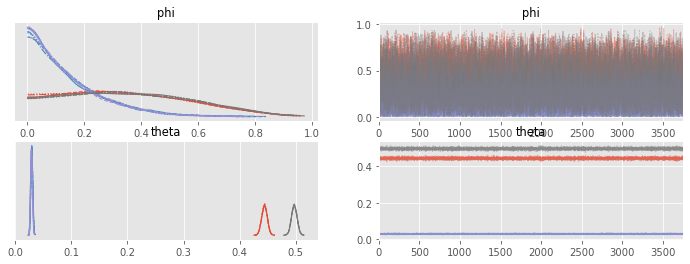

In [17]:
axs = dm_model.plot_prior_trace()

### Posterior traces

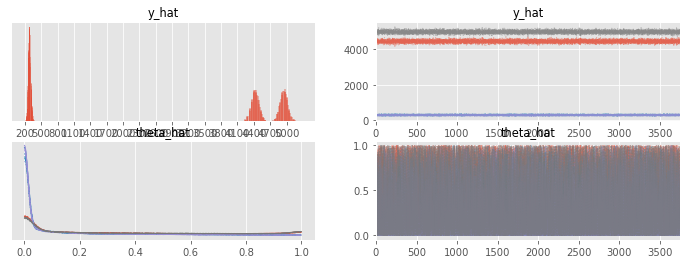

In [18]:
axs = dm_model.plot_posterior_trace()

### Generative posterior

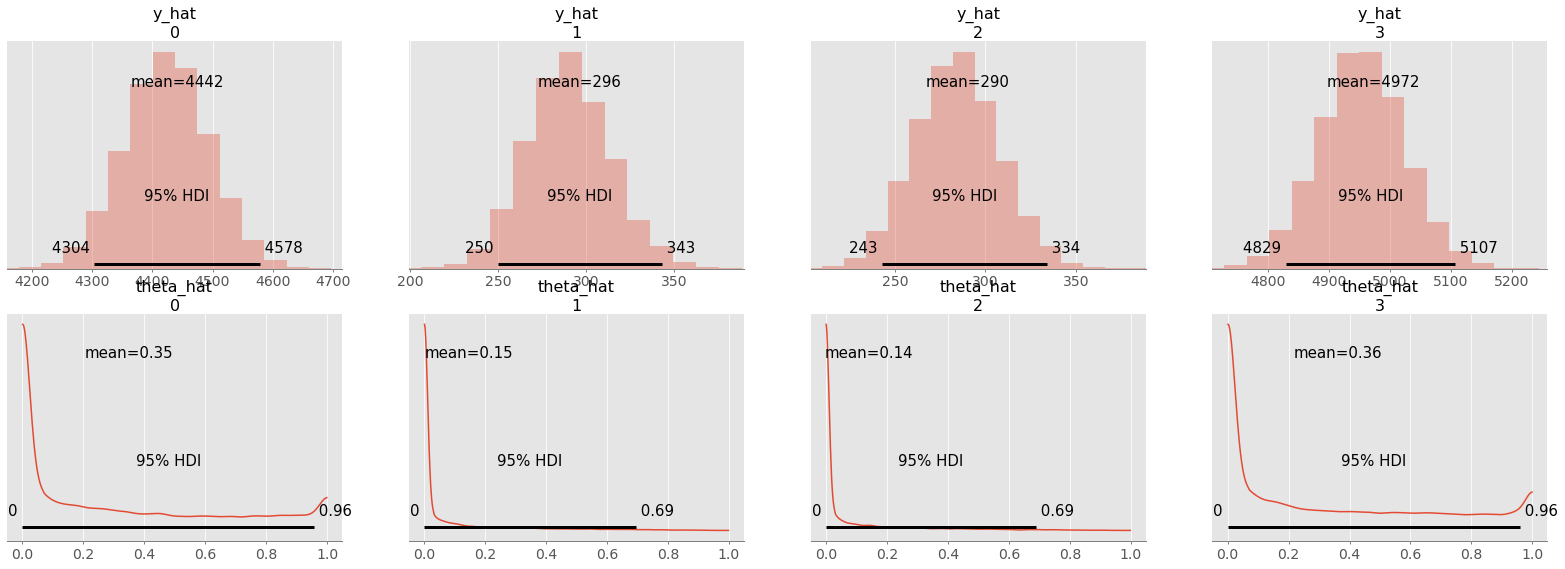

In [19]:
axs = dm_model.plot_posterior()

### Estimated metrics

In [ ]:
mtr = mmu.metrics_to_dataframe(
    dm_model.compute_metrics(metrics=target_metrics),
    target_metrics
)

In [ ]:
_ = plot_metric_distributions(mtr, gt_metrics)

In [ ]:
_ = sns.pairplot(mtr, diag_kind='kde')

### Compute Highest Density Interval (HDI)

#### Predictive samples from Confusion Matrix

In [ ]:
dm_model.posterior_predictive_hdi()

In [ ]:
_ = dm_model.plot_hdi_predictive_posterior()

#### Metrics based on Confusion Matrix

In [ ]:
_ = dm_model.plot_hdi(metrics=['pos.prec', 'pos.rec'])

In [ ]:
fig, ax = dm_model.plot_hdi()

### Coverage

In [ ]:
holdout_metrics_moments = pd.concat(
    (
        holdout_metrics.apply([np.min, np.max, np.mean]).T,
         mmu.metrics.compute_hdi(holdout_metrics)
    ), axis=1
)
holdout_metrics_moments

HDI estimates

In [ ]:
hdi_estimates = mmu.metrics.compute_hdi(mtr)
hdi_estimates['mu'] = mtr.values.mean(0)

In [ ]:
hdi_estimates

## Coverage

In [ ]:
coverage_counts = ((holdout_metrics - hdi_estimates['lb'].T) < 0.0).sum().to_frame()
coverage_counts.columns = ['<lb']
coverage_counts['>ub'] = ((holdout_metrics - hdi_estimates['ub'].T) > 0.0).sum()

coverage_counts['under_coverage'] = coverage_counts.sum(1)

coverage_counts['under_coverage_perc'] = (
    (coverage_counts['under_coverage'] / holdout_metrics.shape[0])
    * 100
)

In [ ]:
coverage_counts

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

_ = sns.violinplot(
    data=holdout_metrics,
    saturation=0.1,
    ax=ax,
    color=COLORS[3],
    zorder=5,
    label='out-of-sample',
)
violin = mpatches.Patch(color=COLORS[3], label='out-of-sample')

for i, idx in enumerate(hdi_estimates.index):
    mu = hdi_estimates.loc[idx, 'mu']
    lb = hdi_estimates.loc[idx, 'lb']
    ub = hdi_estimates.loc[idx, 'ub']
    err = np.abs(np.array([lb, ub])[:, None] - mu)
    ax.errorbar(
        x=i - 0.1, y=mu, yerr=err, capsize=10, fmt='none',
        color=COLORS[0], zorder=10, lw=2, label='HDI estimate'
    );
    ax.scatter(
        x=i - 0.1, y=mu, marker='d', s=100, color=COLORS[0],
        zorder=10, label='mean estimate'
    )

    mu = holdout_metrics_moments.loc[idx, 'mean']
    lb = holdout_metrics_moments.loc[idx, 'lb']
    ub = holdout_metrics_moments.loc[idx, 'ub']
    err = np.abs(np.array([lb, ub])[:, None] - mu)
    ax.errorbar(
        x=i + 0.1, y=mu, yerr=err, capsize=10,
        fmt='none', color=COLORS[1], label='HDI out-of-sample', zorder=10, lw=2
    );
    ax.scatter(
        x=i + 0.1, y=mu, marker='d', s=100, color=COLORS[1], zorder=10,
        label='mean out-of-sample'
    )



_ = ax.set_xticks([i for i in range(len(target_metrics))])
_ = ax.set_xticklabels(target_metrics)

ax.set_title('Coverage metrics', fontsize=18)
ax.set_ylabel('value', fontsize=18)
ax.set_xlabel('metrics', fontsize=18)
ax.tick_params(labelsize=16)
ax.legend(fontsize=18)

handles, labels = plt.gca().get_legend_handles_labels()
handles = [violin, ] + handles
labels = ['out-of-sample'] + labels
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [ ]:
fig, axs = plt.subplots(figsize=(50, 10), ncols=5, sharey=True)
for i, idx in enumerate(hdi_estimates.index):
    ax = axs[i]
    sns.kdeplot(
        mtr[idx],
        clip=(mtr[idx].min(), mtr[idx].max()),
        ax=ax,
        label='estimated',
        color=COLORS[0]
    )
    x, y = ax.get_lines()[0].get_data()
    shade_idx = (x > hdi_estimates.loc[idx, 'lb']) & (x < hdi_estimates.loc[idx, 'ub'])
    ax.fill_between(
        x=x[shade_idx],
        y1=y[shade_idx],
        alpha=0.3,
        label='HDI estimate',
        color=COLORS[0]
    )

    ax.axvline(
        x=holdout_metrics_moments.loc[idx, 'lb'],
        color=COLORS[1],
        ls='--',
        label='HDI hold-out'
    )
    ax.axvline(x=holdout_metrics_moments.loc[idx, 'ub'], color=COLORS[1], ls='--')
    ax.axvline(
        x=holdout_metrics_moments.loc[idx, 'amin'],
        color=COLORS[3],
        ls='dotted',
        lw=3,
        label='range hold-out'
    )
    ax.axvline(x=holdout_metrics_moments.loc[idx, 'amax'], color=COLORS[3], ls='dotted', lw=3)
    ax.legend()
    ax.set_ylabel('density', fontsize=16)
    ax.set_xlabel(idx, fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=16);
    fig.suptitle('Estimated vs observed out-of-sample performance', fontsize=20)